In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Configuración ---
# Define el directorio donde se guardará la imagen del gráfico
output_dir = "/data/training2/analisis_TFM_Bulida_Precoz/TFM_Bulida_Precoz_Repository/7_Pre-print"
os.makedirs(output_dir, exist_ok=True)

# Define el nombre del fichero de entrada
summary_file = os.path.join(output_dir, "02_final_candidates_expanded_thresholds/expanded_threshold_candidate_summary.txt")

print("Setup complete.")

Setup complete.


In [2]:
try:
    df_summary = pd.read_csv(summary_file, sep='\t')
    
    # Asegurarse de que los datos están ordenados por el porcentaje para un gráfico correcto
    df_summary = df_summary.sort_values(by='Threshold_Percent')
    
    print("--- Mutect2 Filtering Experiment Summary ---")
    print(df_summary.to_string(index=False))

except FileNotFoundError:
    print(f"ERROR: Summary file not found at: {summary_file}")
    df_summary = None

--- Mutect2 Filtering Experiment Summary ---
 Threshold_Percent  Final_Candidate_Count
                 3                    123
                 5                    122
                 7                    121
                12                    117
                15                    112
                20                    101
                25                     95
                30                     82
                35                     75
                50                     49



Plot saved correctly to: /data/training2/analisis_TFM_Bulida_Precoz/TFM_Bulida_Precoz_Repository/7_Pre-print/mutect2_filtering_threshold_effect.png


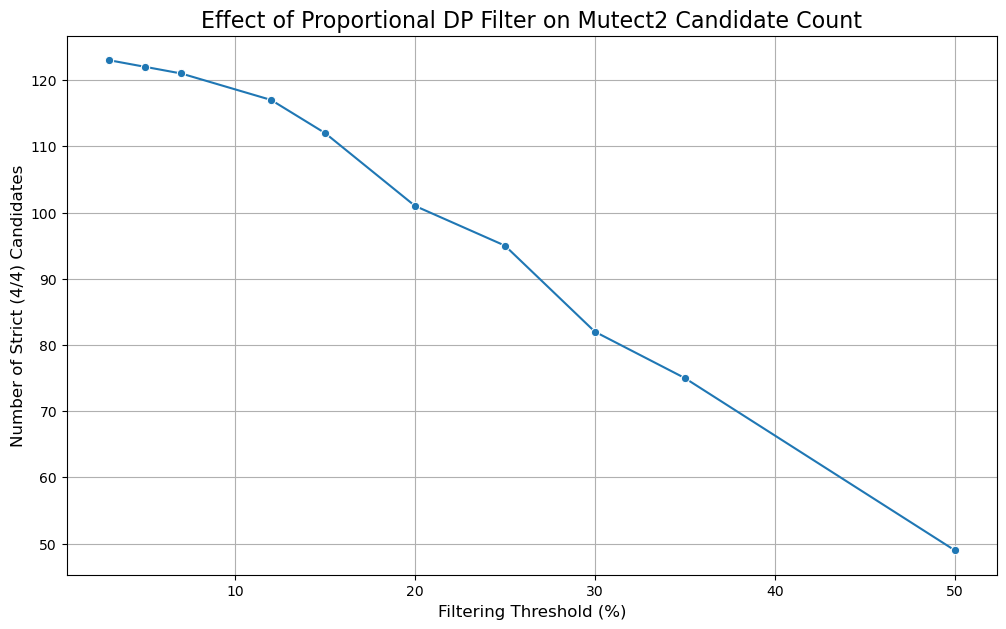

In [3]:
if df_summary is not None:
    # Crear la figura para el gráfico
    plt.figure(figsize=(12, 7))

    # Generar el gráfico de líneas con Seaborn, añadiendo marcadores en los puntos
    line_plot = sns.lineplot(
        data=df_summary,
        x='Threshold_Percent',
        y='Final_Candidate_Count',
        marker='o'  # Añade puntos en cada dato
    )

    # Añadir títulos y etiquetas (actualizados para Mutect2)
    line_plot.set_title('Effect of Proportional DP Filter on Mutect2 Candidate Count', fontsize=16)
    line_plot.set_xlabel('Filtering Threshold (%)', fontsize=12)
    line_plot.set_ylabel('Number of Strict (4/4) Candidates', fontsize=12)
    plt.grid(True)
    
    # Guardar la figura en un fichero
    plot_path = os.path.join(output_dir, 'mutect2_filtering_threshold_effect.png')
    plt.savefig(plot_path, bbox_inches='tight')
    
    print(f"\nPlot saved correctly to: {plot_path}")

    # Mostrar el gráfico en el notebook
    plt.show()
    plt.close()
else:
    print("Could not generate plot because the data was not loaded.")

## LOH Variants

In [4]:
# --- 1. Imports and Setup ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import subprocess
import io

# --- Configuration ---
# Define the base directory where the script is running
base_dir = "/data/training2/analisis_TFM_Bulida_Precoz/TFM_Bulida_Precoz_Repository/7_Pre-print"

# --- Input Files ---
# The annotated table of LOH candidates you just created
loh_table_path = os.path.join(base_dir, "inverse_candidates_0_vs_4_annotated_table.tsv")
# The VCF with all 8 samples needed to get VAF data
vcf_for_vaf_query = "/data/training2/analisis_TFM_Bulida_Precoz/08_parameter_change_analysis/GATK_HaplotypeCaller_workflow/01_proportional_filtering/final_bcftools_propDP_15pct.filtered.vcf.gz"

# --- Output Directory ---
# We will save plots and tables in the current directory
output_dir = base_dir

print("Setup complete.")

Setup complete.


In [5]:
# --- 2. Load and Parse LOH Candidate Data ---
try:
    # Load the annotated table
    df_loh_full = pd.read_csv(loh_table_path, sep='\t', header=None, names=['CHROM', 'POS', 'REF', 'ALT', 'ANN'])
    
    # Parse the SnpEff ANN field to extract Impact, Effect, and Gene ID
    ann_fields = df_loh_full['ANN'].str.split('|', expand=True)
    df_loh_full['IMPACT'] = ann_fields[2]
    df_loh_full['EFFECT'] = ann_fields[1]
    df_loh_full['GENE_ID'] = ann_fields[4]
    
    print(f"--- Analysis of Loss-of-Heterozygosity (LOH) Candidates ---")
    print(f"\nLoaded {len(df_loh_full)} total LOH candidates.")
    
except FileNotFoundError:
    print(f"ERROR: LOH candidate table not found at: {loh_table_path}")
    df_loh_full = None

--- Analysis of Loss-of-Heterozygosity (LOH) Candidates ---

Loaded 105 total LOH candidates.



--- Count by Impact (All LOH Candidates) ---
IMPACT
MODIFIER    101
MODERATE      2
LOW           2
Name: count, dtype: int64

--- Top 10 Predicted Effects (All LOH Candidates) ---
EFFECT
upstream_gene_variant      42
intergenic_region          32
downstream_gene_variant    18
3_prime_UTR_variant         6
missense_variant            2
intron_variant              2
synonymous_variant          2
5_prime_UTR_variant         1
Name: count, dtype: int64


/tmp/ipykernel_1649739/2509414087.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='IMPACT', data=df_loh_full, order=df_loh_full['IMPACT'].value_counts().index, palette='viridis')


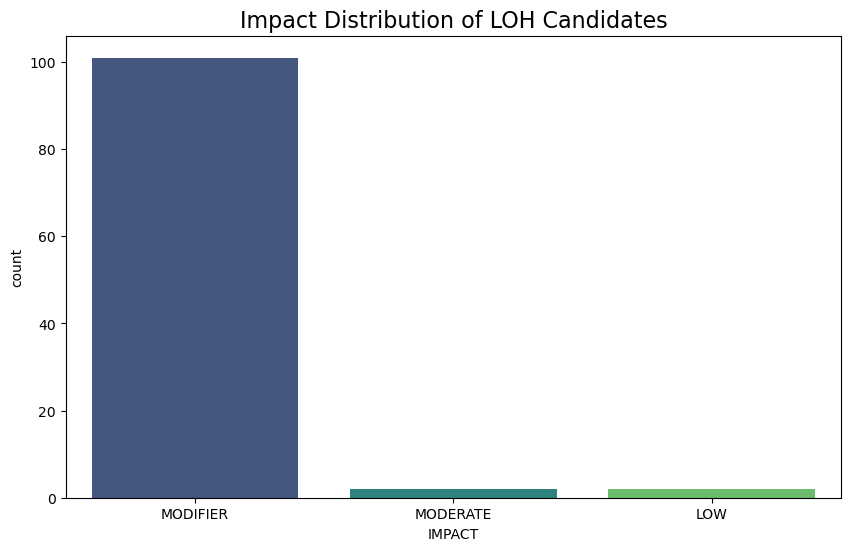

/tmp/ipykernel_1649739/2509414087.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='EFFECT', data=df_loh_full, order=df_loh_full['EFFECT'].value_counts().head(10).index, palette='crest')


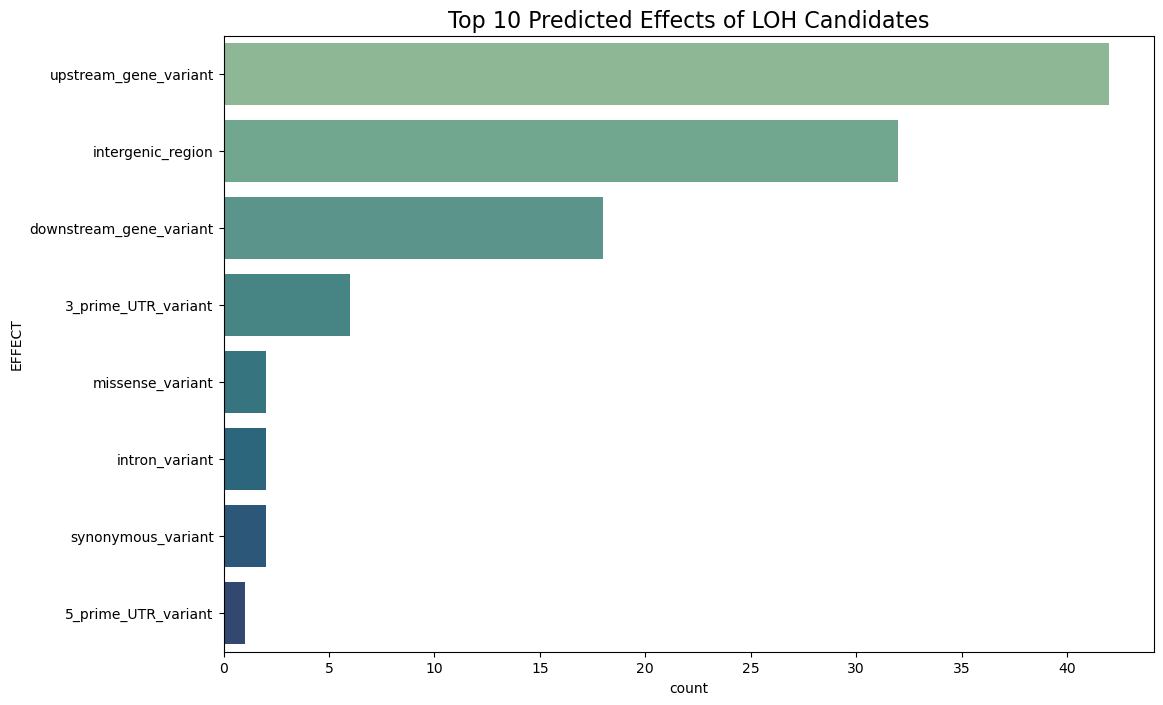

In [6]:
# --- 3. Global Analysis of LOH Candidates ---
if df_loh_full is not None:
    # --- Text Summaries ---
    print("\n--- Count by Impact (All LOH Candidates) ---")
    print(df_loh_full['IMPACT'].value_counts())
    
    print("\n--- Top 10 Predicted Effects (All LOH Candidates) ---")
    print(df_loh_full['EFFECT'].value_counts().head(10))
    
    # --- Plot 1: Distribution of Impacts ---
    plt.figure(figsize=(10, 6))
    sns.countplot(x='IMPACT', data=df_loh_full, order=df_loh_full['IMPACT'].value_counts().index, palette='viridis')
    plt.title('Impact Distribution of LOH Candidates', fontsize=16)
    plt.savefig(os.path.join(output_dir, 'loh_candidates_impact_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()
    
    # --- Plot 2: Top 10 Effects ---
    plt.figure(figsize=(12, 8))
    sns.countplot(y='EFFECT', data=df_loh_full, order=df_loh_full['EFFECT'].value_counts().head(10).index, palette='crest')
    plt.title('Top 10 Predicted Effects of LOH Candidates', fontsize=16)
    plt.savefig(os.path.join(output_dir, 'loh_candidates_effects_plot.png'), bbox_inches='tight')
    plt.show()
    plt.close()


--- Found 2 LOH candidates with HIGH or MODERATE impact ---


,CHROM,POS,REF,ALT,EFFECT,IMPACT,GENE_ID
50,BULcur4G,4532858,C,A,missense_variant,MODERATE,Gene_26784
94,BULcur7G,11993966,T,C,missense_variant,MODERATE,Gene_45148


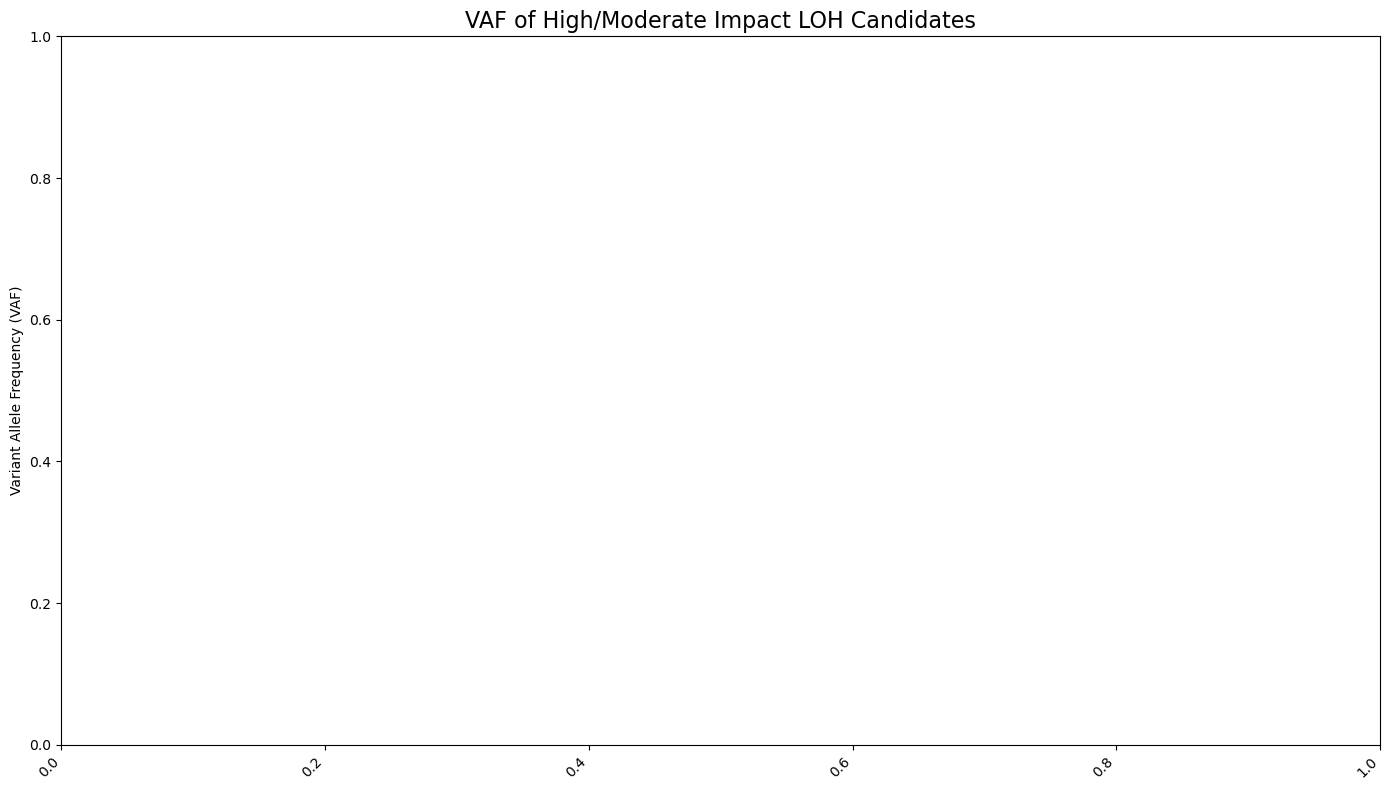

In [7]:
# --- 4. Prioritize High/Moderate Impact Candidates and Analyze VAF ---
if df_loh_full is not None:
    # Filter for the most promising candidates
    df_loh_top = df_loh_full[df_loh_full['IMPACT'].isin(['HIGH', 'MODERATE'])].copy()
    
    print(f"\n--- Found {len(df_loh_top)} LOH candidates with HIGH or MODERATE impact ---")
    display(df_loh_top[['CHROM', 'POS', 'REF', 'ALT', 'EFFECT', 'IMPACT', 'GENE_ID']])

    if not df_loh_top.empty:
        # --- VAF Analysis ---
        # Extract AD and DP from the original VCF for all 8 samples for our top LOH candidates
        vcf_regions = df_loh_top[['CHROM', 'POS']].copy()
        vcf_regions['END'] = vcf_regions['POS']
        regions_path = os.path.join(output_dir, 'temp_loh_regions.bed')
        vcf_regions.to_csv(regions_path, sep='\t', header=False, index=False)

        sample_order = 'mt1,mt2,mt3,mt4,wt1,wt2,wt3,wt4'
        
        bcf_command = f"bcftools query -f '%CHROM\t%POS\t%REF\t%ALT[\t%AD\t%DP]\n' -R {regions_path} {vcf_for_vaf_query}"
        
        try:
            result = subprocess.run(bcf_command, shell=True, check=True, capture_output=True, text=True)
            data_io = io.StringIO(result.stdout)
            column_names = ['CHROM', 'POS', 'REF', 'ALT'] + [f'{tag}_{s}' for s in sample_order.split(',') for tag in ['AD', 'DP']]
            df_vaf_raw = pd.read_csv(data_io, sep='\t', header=None, names=column_names)

            # Process data to calculate VAF for all 8 samples
            vaf_data = []
            for _, row in df_vaf_raw.iterrows():
                variant_name = f"{row['REF']}{row['POS']}{row['ALT']}"
                for sample in sample_order.split(','):
                    ad_str = str(row[f'AD_{sample}'])
                    dp = pd.to_numeric(row[f'DP_{sample}'], errors='coerce')
                    if pd.notna(dp) and dp > 0 and ',' in ad_str:
                        alt_depth = int(ad_str.split(',')[1])
                        vaf = alt_depth / dp
                        sample_type = 'Mutant' if 'mt' in sample else 'Wild-Type'
                        vaf_data.append([variant_name, sample, vaf, sample_type])
            
            df_vaf = pd.DataFrame(vaf_data, columns=['Variant', 'Sample', 'VAF', 'Sample Type'])

            # --- Plotting VAF ---
            plt.figure(figsize=(14, 8))
            sns.barplot(x='Variant', y='VAF', hue='Sample', data=df_vaf)
            plt.title('VAF of High/Moderate Impact LOH Candidates', fontsize=16)
            plt.xticks(rotation=45, ha='right')
            plt.ylabel("Variant Allele Frequency (VAF)")
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, 'loh_candidates_vaf_plot.png'), bbox_inches='tight')
            plt.show()
            plt.close()
            
            # Cleanup temporary file
            os.remove(regions_path)

        except Exception as e:
            print(f"An error occurred during VAF analysis: {e}")

## Pairwise Comparison

In [8]:
# --- 1. Imports and Setup ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- Configuration ---
# Define la ruta a tu fichero de resultados
summary_file = "/data/training2/analisis_TFM_Bulida_Precoz/09_samples_double_check/pairwise_comparison_all/full_pairwise_comparison_summary.txt"

# Define dónde se guardará la imagen del gráfico
output_dir = "/data/training2/analisis_TFM_Bulida_Precoz/09_samples_double_check/pairwise_comparison_all"
os.makedirs(output_dir, exist_ok=True)

print("Setup complete.")

Setup complete.


In [9]:
# --- 2. Load Data and Calculate Jaccard Similarity ---
try:
    df = pd.read_csv(summary_file, sep='\t')
    
    # Calcular el total de variantes únicas entre cada par
    total_variants = df['Unique_To_Sample1'] + df['Unique_To_Sample2'] + df['Shared_Variants']
    
    # Calcular el Índice de Jaccard y añadirlo como una nueva columna
    df['Jaccard_Similarity'] = df['Shared_Variants'] / total_variants
    
    print("--- Pairwise Comparison with Jaccard Similarity ---")
    display(df[['Sample1', 'Sample2', 'Shared_Variants', 'Jaccard_Similarity']].head())

except FileNotFoundError:
    print(f"ERROR: Summary file not found at: {summary_file}")
    df = None

--- Pairwise Comparison with Jaccard Similarity ---


,Sample1,Sample2,Shared_Variants,Jaccard_Similarity
0,mt1,mt2,971697,0.969744
1,mt1,mt3,975212,0.970802
2,mt1,mt4,975778,0.971694
3,mt1,wt1,973656,0.972173
4,mt1,wt2,972793,0.971101


In [10]:
# --- 3. Reshape Data into a Similarity Matrix ---
if df is not None:
    # Usa pivot para crear la matriz de similaridad
    similarity_matrix = df.pivot(index='Sample1', columns='Sample2', values='Jaccard_Similarity')
    
    # La matriz está a la mitad, la completamos para que sea simétrica
    all_samples = np.union1d(df['Sample1'], df['Sample2'])
    similarity_matrix = similarity_matrix.reindex(index=all_samples, columns=all_samples)
    
    # Rellenar la otra mitad de la matriz y la diagonal
    similarity_matrix = similarity_matrix.add(similarity_matrix.T, fill_value=0)
    np.fill_diagonal(similarity_matrix.values, 1) # Cada muestra es 100% similar a sí misma
    
    print("\n--- Similarity Matrix Ready for Plotting ---")
    display(similarity_matrix)


--- Similarity Matrix Ready for Plotting ---


Sample2,mt1,mt2,mt3,mt4,wt1,wt2,wt3,wt4
Sample1,,,,,,,,
mt1,1.000000,0.969744,0.970802,0.971694,0.972173,0.971101,0.972185,0.971078
mt2,0.969744,1.000000,0.967614,0.968158,0.969903,0.969492,0.968883,0.968043
mt3,0.970802,0.967614,1.000000,0.983452,0.972080,0.969647,0.982377,0.982211
mt4,0.971694,0.968158,0.983452,1.000000,0.972187,0.970189,0.983304,0.982729
wt1,0.972173,0.969903,0.972080,0.972187,1.000000,0.972131,0.973482,0.972402
wt2,0.971101,0.969492,0.969647,0.970189,0.972131,1.000000,0.971463,0.970321
wt3,0.972185,0.968883,0.982377,0.983304,0.973482,0.971463,1.000000,0.983058
wt4,0.971078,0.968043,0.982211,0.982729,0.972402,0.970321,0.983058,1.000000



Heatmap saved correctly to: /data/training2/analisis_TFM_Bulida_Precoz/09_samples_double_check/pairwise_comparison_all/sample_similarity_heatmap.png


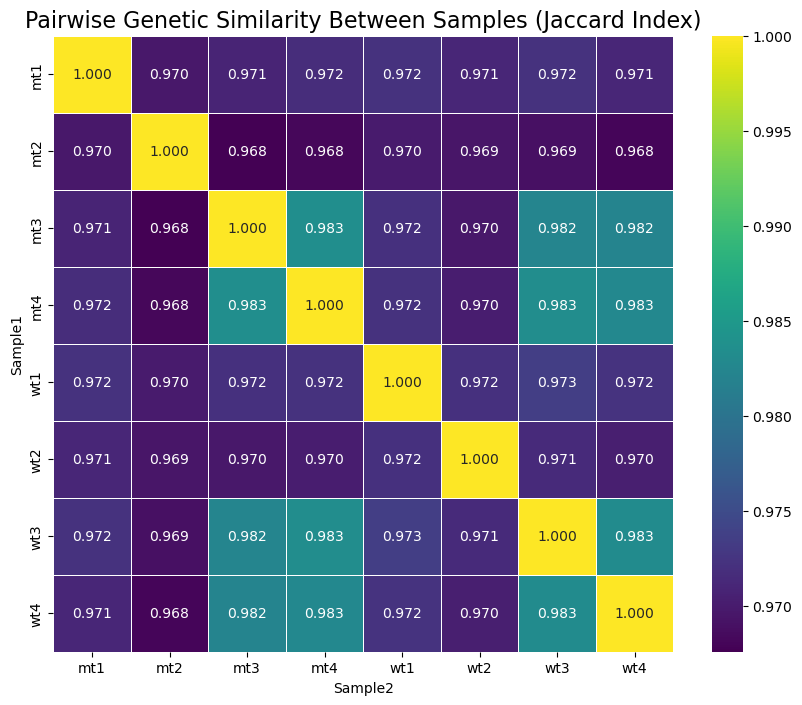

In [11]:
# --- 4. Generate and Save the Heatmap ---
if 'similarity_matrix' in locals():
    plt.figure(figsize=(10, 8))
    
    # Crear el heatmap con Seaborn
    heatmap = sns.heatmap(
        similarity_matrix,
        annot=True,          # Muestra los valores en las celdas
        cmap='viridis',      # Paleta de colores (más alto = más similar)
        fmt='.3f',           # Formato de los números a 3 decimales
        linewidths=.5
    )
    
    plt.title('Pairwise Genetic Similarity Between Samples (Jaccard Index)', fontsize=16)
    
    # Guardar la figura
    plot_path = os.path.join(output_dir, 'sample_similarity_heatmap.png')
    plt.savefig(plot_path, bbox_inches='tight')
    
    print(f"\nHeatmap saved correctly to: {plot_path}")
    
    # Mostrar el gráfico
    plt.show()
    plt.close()